In [1]:
%run ../flaubert_token_classification.py
%run ../tools/utils_ner.py

In [2]:
import datetime
import math
import os

import matplotlib.pyplot as plt
import itertools
import numpy as np
import tensorflow as tf
from seqeval import metrics
from transformers import (
    TF2_WEIGHTS_NAME,
    FlaubertConfig,
    FlaubertTokenizer,
    GradientAccumulator,
    create_optimizer
)

# Parameters

In [3]:
ROOT_FOLDER = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/"

In [4]:
## Model parameters

MODEL_PATH = ROOT_FOLDER + "models/ner/"
LOG_PATH = ROOT_FOLDER + "logs/ner/"

model_name="jplu/tf-flaubert-base-cased"

max_seq_length=64
batch_size=64
epochs=3
learning_rate=5e-5
max_grad_norm=1.0
warmup_steps=0
pad_token_label_id = -1

In [5]:
## Dataset parameters

DATASET_PATH = ROOT_FOLDER + "dataset/wikiNer/"
LABEL_PATH = DATASET_PATH + "labels.txt"

labels, num_labels = get_labels(LABEL_PATH)

In [6]:
## Random parameters

save_steps=1500
logging_steps=100
seed=42
no_cuda=False

# Import dataset

In [7]:
def load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode):
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        DATASET_PATH,
        "cached_{}_{}_{}.tf_record".format(
            mode, list(filter(None, model_name.split("/"))).pop(), str(max_seq_length)
        ),
    )
    if os.path.exists(cached_features_file):
        logging.info("Loading features from cached file %s", cached_features_file)
        dataset, size = load_cache(cached_features_file, max_seq_length)
    else:
        print("Creating features from dataset file at", DATASET_PATH)
        examples = read_examples_from_file(DATASET_PATH, mode)
        features = convert_examples_to_features(
            examples,
            labels,
            max_seq_length,
            tokenizer,
            cls_token_at_end=False,
            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            cls_token_segment_id=0,
            sep_token=tokenizer.sep_token,
            sep_token_extra=False, # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
            pad_on_left=False, # pad on the left for xlnet
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=0,
            pad_token_label_id=pad_token_label_id,
        )

        save_cache(features, cached_features_file)
        dataset, size = load_cache(cached_features_file, max_seq_length)

    if mode == "train":
        dataset = dataset.repeat()
        dataset = dataset.shuffle(buffer_size=8192, seed=seed)

    dataset = dataset.batch(batch_size, True)
    dataset = dataset.prefetch(buffer_size=batch_size)

    return dataset, size

# Training

In [8]:
def train(strategy, train_dataset, tokenizer, model, num_train_examples, labels, pad_token_label_id):
    num_train_steps = math.ceil(num_train_examples / batch_size) // epochs

    writer = tf.summary.create_file_writer("/tmp/mylogs")

    with strategy.scope():
        loss_fct = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        optimizer = create_optimizer(learning_rate, num_train_steps, warmup_steps)
        loss_metric = tf.keras.metrics.Mean(name="loss", dtype=tf.float32)
        gradient_accumulator = GradientAccumulator()

    model.summary()

    @tf.function
    def apply_gradients():
        grads_and_vars = []

        for gradient, variable in zip(gradient_accumulator.gradients, model.trainable_variables):
            if gradient is not None:
                grads_and_vars.append((gradient, variable))
            else:
                grads_and_vars.append((gradient, variable))

        optimizer.apply_gradients(grads_and_vars, max_grad_norm)
        gradient_accumulator.reset()

    @tf.function
    def train_step(train_features, train_labels):
        def step_fn(train_features, train_labels):
            inputs = {
                "attention_mask": train_features["input_mask"],
                "token_type_ids": train_features["segment_ids"],
                "training": True
            }

            with tf.GradientTape() as tape:
                logits = model(train_features["input_ids"], **inputs)[0]
                active_loss = tf.reshape(train_labels, (-1,)) != pad_token_label_id
                active_logits = tf.boolean_mask(tf.reshape(logits, (-1, len(labels))), active_loss)
                active_labels = tf.boolean_mask(tf.reshape(train_labels, (-1,)), active_loss)
                cross_entropy = loss_fct(active_labels, active_logits)
                loss = tf.reduce_sum(cross_entropy) * (1.0 / batch_size)
                grads = tape.gradient(loss, model.trainable_variables)

                gradient_accumulator(grads)

            return cross_entropy

        per_example_losses = strategy.experimental_run_v2(step_fn, args=(train_features, train_labels))
        mean_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_example_losses, axis=0)

        return mean_loss

    current_time = datetime.datetime.now()
    global_step = 0
    logging_loss = 0.0

    for _ in range(epochs):
        step = 1

        with strategy.scope():
            for train_features, train_labels in train_dataset:
                loss = train_step(train_features, train_labels)
                strategy.experimental_run_v2(apply_gradients)
                loss_metric(loss)
                global_step += 1

                # Log metrics
                if logging_steps > 0 and global_step % logging_steps == 0:
                    lr = optimizer.learning_rate
                    learning_rate_step = lr(step)

                    with writer.as_default():
                        tf.summary.scalar("lr", learning_rate_step, global_step)
                        tf.summary.scalar("loss", (loss_metric.result() - logging_loss) / logging_steps, global_step)

                    logging_loss = loss_metric.result()

                with writer.as_default():
                    tf.summary.scalar("loss", loss_metric.result(), step=step)

                # Save model checkpoint
                if save_steps > 0 and global_step % save_steps == 0:
                    checkpoint_output_dir = os.path.join(MODEL_PATH, "checkpoint-{}".format(global_step))

                    if not os.path.exists(checkpoint_output_dir):
                        os.makedirs(checkpoint_output_dir)

                    model.save_pretrained(checkpoint_output_dir)
                    print("Saving model checkpoint to", checkpoint_output_dir)

                step += 1

            loss_metric.reset_states()

    print("  Training took time = {}".format(datetime.datetime.now() - current_time))

In [9]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

config = FlaubertConfig.from_pretrained(model_name, num_labels=num_labels)

with strategy.scope():
    model = TFFlaubertForTokenClassification.from_pretrained(MODEL_PATH, config=config)
    tokenizer = FlaubertTokenizer.from_pretrained(model_name)

In [10]:
train_dataset, num_train_examples = load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode="train")
train_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [11]:
train(strategy, train_dataset, tokenizer, model, num_train_examples, labels, pad_token_label_id)

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

print("Saving model to", MODEL_PATH)

model.save_pretrained(MODEL_PATH)

del train_dataset, num_train_examples

# Evaluation

In [12]:
def evaluate(strategy, model, tokenizer, labels, pad_token_label_id, mode):
    eval_dataset, size = load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode=mode)
    eval_dataset = strategy.experimental_distribute_dataset(eval_dataset)
    preds = None
    
    input_ids = []
    
    loss_fct = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    loss = 0.0

    idx = 0
    for eval_features, eval_labels in eval_dataset:
        idx += 1
        if idx > 200:
            break
        inputs = {
            "attention_mask": eval_features["input_mask"],
            "token_type_ids": eval_features["segment_ids"],
            "training": False
        }

        with strategy.scope():
            logits = model(eval_features["input_ids"], **inputs)[0]
            active_loss = tf.reshape(eval_labels, (-1,)) != pad_token_label_id
            active_logits = tf.boolean_mask(tf.reshape(logits, (-1, len(labels))), active_loss)
            active_labels = tf.boolean_mask(tf.reshape(eval_labels, (-1,)), active_loss)
            cross_entropy = loss_fct(active_labels, active_logits)
            loss += tf.reduce_sum(cross_entropy) * (1.0 / batch_size)

        input_ids.append(eval_features["input_ids"])
        if preds is None:
            preds = logits.numpy()
            label_ids = eval_labels.numpy()
        else:
            preds = np.append(preds, logits.numpy(), axis=0)
            label_ids = np.append(label_ids, eval_labels.numpy(), axis=0)

    preds = np.argmax(preds, axis=2)
    y_pred = [[] for _ in range(label_ids.shape[0])]
    y_true = [[] for _ in range(label_ids.shape[0])]

    for i in range(label_ids.shape[0]):
        for j in range(label_ids.shape[1]):
            if label_ids[i, j] != pad_token_label_id:
                #y_pred[i].append(labels[preds[i, j]])
                #y_true[i].append(labels[label_ids[i, j] ])
                y_pred[i].append(preds[i, j])
                y_true[i].append(label_ids[i, j])

                
    return y_true, y_pred, loss.numpy(), input_ids

In [13]:
y_true, y_pred, eval_loss, input_ids = evaluate(strategy, model, tokenizer, labels, pad_token_label_id, mode="dev")

export = open("export.csv", "w")
export.write("sentence; true; pred\n")
for idx, (true, pred, ids) in enumerate(zip(y_true, y_pred, input_ids)):
    if true != pred:
        sentence = tokenizer.convert_ids_to_tokens(ids[idx % 64])
        sentence = "".join([word.replace("</w>", "") + " " if "</w>" in word else word for word in sentence]).replace("<pad>", "")
        true = " ".join([str(a) for a in true])
        pred = " ".join([str(a) for a in pred])
        export.write(sentence + "; " + true + "; " + pred + "\n")
export.close()

In [14]:
report = metrics.classification_report(y_true, y_pred, digits=2)

output_eval_file = os.path.join(MODEL_PATH, "eval_results.txt")
with tf.io.gfile.GFile(output_eval_file, "w") as writer:
    # Log loss
    print("final_loss = " + str(eval_loss))
    writer.write("final_loss = " + str(eval_loss))
    writer.write("\n")

    # Log metrics
    print("final_report")
    print("\n" + report)
    writer.write("final_report" + "\n")
    writer.write(report)
    writer.write("\n")

IndexError: invalid index to scalar variable.

In [15]:
from sklearn.metrics import confusion_matrix

true = [y for x in y_true for y in x]
pred = [y for x in y_pred for y in x]
print(len(true))
print(len(pred))
cm = confusion_matrix(true, pred)
print(cm)

330162
330162
[[     0      0      0      0     20      0      1      0      0]
 [     0      0      0      0      0      4      0      0      0]
 [     0      0      0      0      0      0      3      0      0]
 [     0      0      0      0      0      0      0      9      0]
 [     0      0      0      0  15923    181    163     31    820]
 [     0      0      0      0    124   8162     69     33    215]
 [     0      0      0      0    171     58   5209      9    102]
 [     0      0      0      0     31     53     13  10808     68]
 [     0      0      0      0    460    307    136     67 286912]]


In [16]:
def plot_confusion_matrix(cm, target_names, normalize=True):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title("Confusion matrix")
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

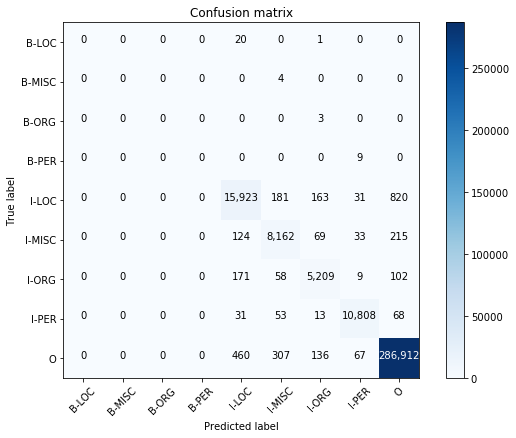

In [17]:
plot_confusion_matrix(cm, normalize = False, target_names=labels)